In [1]:
### Necessary to allow loading of checkpoints ###
import os
import sys
sys.path.append(os.path.join('D:', os.sep, 'Users', 'Julien', 'Documents', 'GitHub', 'diploma_thesis', 'cnn'))
from collections import namedtuple
Genotype = namedtuple("Genotype", "normal normal_concat reduce reduce_concat")
###
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import torch
from datetime import timedelta
from matplotlib.ticker import MultipleLocator

# Constants

In [2]:
seeds = [42, 63]
gpu = "a100"
eval_epochs = [300, 600]

# Path to Checkpoints + Loading

In [64]:
ckpts = {
    seed: {
        epochs: torch.load(os.path.join("H:", os.sep, "DA_Results", "exp_2_extended_std_no_shuffle", gpu, f"gaussian_process-seed_{seed}-epochs_{epochs}", "outer_loop.ckpt"))
        for epochs in eval_epochs
    }
    for seed in seeds
}
stats = list(ckpts[63][300].keys())
random_samples = ckpts[63][300]['number_randomly_sampled']

for seed in seeds:
    for epochs in eval_epochs:
        if ckpts[seed][epochs]['learning_rates'].shape[0] > ckpts[seed][epochs]['valid_errors'].shape[0]:
            ckpts[seed][epochs]['learning_rates'] = ckpts[seed][epochs]['learning_rates'][:-1]

for seed in seeds:
    for epochs in eval_epochs:
        assert ckpts[seed][epochs]['learning_rates'].shape[0] == ckpts[seed][epochs]['valid_errors'].shape[0], f"{ckpts[seed][epochs]['learning_rates'].shape} vs {ckpts[seed][epochs]['valid_errors'].shape}"
#for seed in seeds:
#    for epochs in eval_epochs:
#        assert os.path.isfile(ckpts[seed][epochs]), f"Not a file: {ckpts[seed][epochs]}"

In [24]:
stats

['learning_rates',
 'valid_errors',
 'acquisition_values',
 'incumbent',
 'runtime',
 'number_randomly_sampled',
 'details',
 'rng_state',
 'searched_learning_rates']

# Variables for plotting

In [71]:
GP_iterations = {
    epochs: {
        seed: np.arange(-random_samples, ckpts[seed][epochs]['learning_rates'].shape[0] - random_samples)
        for seed in seeds
    }
    for epochs in eval_epochs    
}

epochs_min_length = {
    epochs: min(ckpts[42][epochs]['valid_errors'].shape[0], ckpts[63][epochs]['valid_errors'].shape[0])
    for epochs in eval_epochs
}

valid_errors = {
    epochs: {
        'combined': np.concatenate(
            [ckpts[seed][epochs]['valid_errors'][:epochs_min_length[epochs]] for seed in seeds],
            axis=1
        )
    }
    for epochs in eval_epochs
}
for epochs in eval_epochs:
    valid_errors[epochs]['mean'] = np.mean(
        valid_errors[epochs]['combined'],
        axis=1
    )
    valid_errors[epochs]['std'] = np.std(
        valid_errors[epochs]['combined'],
        axis=1
    )

# Plots

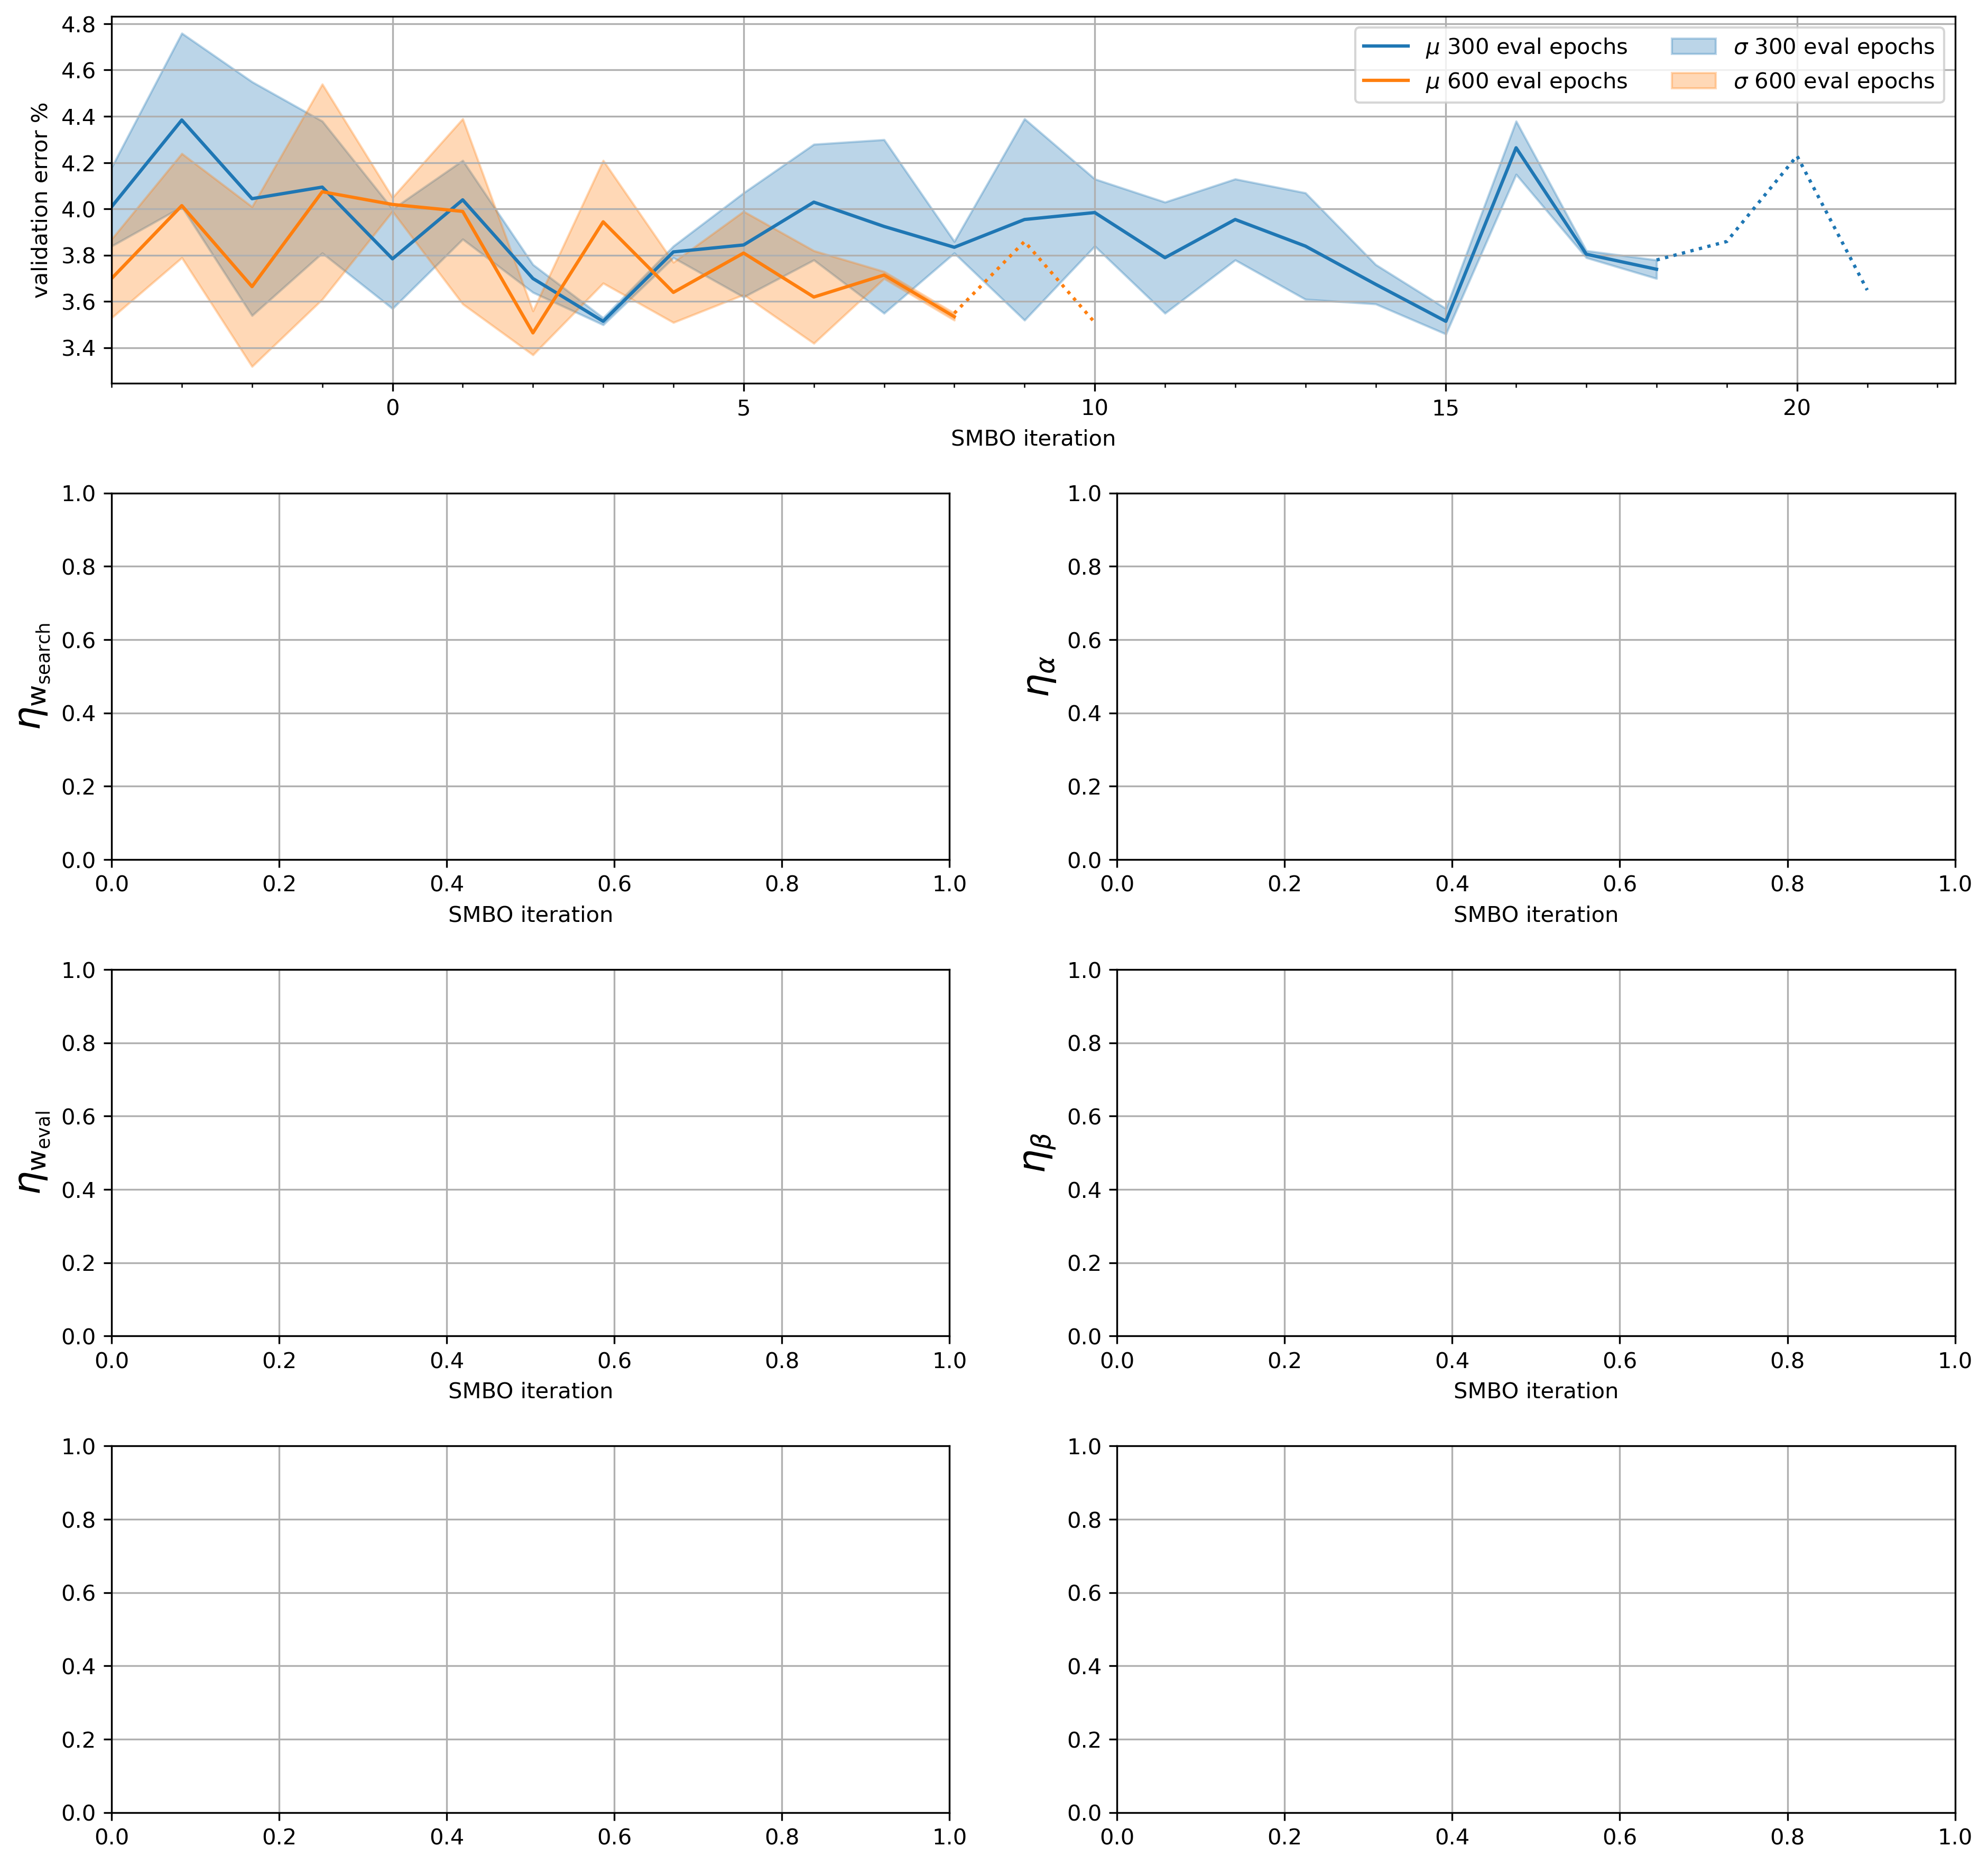

In [128]:
gs = GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1])
fig = plt.figure(figsize=(15,15), dpi=300)
plt.subplots_adjust(hspace=0.3)

error = fig.add_subplot(4,2, (1,2))
eta_w_search = fig.add_subplot(423)
eta_alpha = fig.add_subplot(424)
eta_w_eval = fig.add_subplot(425)
eta_beta = fig.add_subplot(426)
model_weights = fig.add_subplot(427)
architecture_weights = fig.add_subplot(428)

for ax in fig.get_axes():
    ax.grid()

error.set_ylabel('validation error %')
error.set_xlabel('SMBO iteration')
eta_w_search.set_ylabel(r"$\eta_\mathrm{w_{search}}$", fontsize="xx-large")
eta_w_search.set_xlabel("SMBO iteration")
eta_alpha.set_ylabel(r"$\eta_\alpha$", fontsize="xx-large")
eta_alpha.set_xlabel("SMBO iteration")
eta_w_eval.set_ylabel(r"$\eta_\mathrm{w_{eval}}$", fontsize="xx-large")
eta_w_eval.set_xlabel("SMBO iteration")
eta_beta.set_ylabel(r"$\eta_\beta$", fontsize="xx-large")
eta_beta.set_xlabel("SMBO iteration")
error.xaxis.set_minor_locator(MultipleLocator(1))


# plot train and validation error progression with GP iteration

error.plot(
    np.arange(-random_samples, valid_errors[300]['combined'].shape[0]-random_samples),
    valid_errors[300]['mean'],
    color="C0"
)
error.plot(
    np.arange(-random_samples, valid_errors[600]['combined'].shape[0]-random_samples),
    valid_errors[600]['mean'],
    color="C1"
)

error.fill_between(
    np.arange(-random_samples, valid_errors[300]['combined'].shape[0]-random_samples),
    valid_errors[300]['mean'] - valid_errors[300]['std'],
    valid_errors[300]['mean'] + valid_errors[300]['std'],
    alpha=0.3,
    color="C0"
)
error.fill_between(
    np.arange(-random_samples, valid_errors[600]['combined'].shape[0]-random_samples),
    valid_errors[600]['mean'] - valid_errors[600]['std'],
    valid_errors[600]['mean'] + valid_errors[600]['std'],
    alpha=0.3,
    color="C1"
)

error.plot(
    GP_iterations[300][63][epochs_min_length[300]-1:],
    ckpts[63][300]['valid_errors'][epochs_min_length[300]-1:].reshape(-1),
    color="C0",
    linestyle="dotted",
    label="_nolegend_"
)
#error.plot(
#    GP_iterations[300][42],
#    ckpts[42][300]['valid_errors'].reshape(-1),
#    color="C0",
#    linestyle="dashed"
#)
error.plot(
    GP_iterations[600][63][epochs_min_length[600]-1:],
    ckpts[63][600]['valid_errors'][epochs_min_length[600]-1:].reshape(-1),
    color="C1",
    linestyle="dotted",
    label="_nolegend_"
)

error.set_xlim(left=-4)
error.legend(
    [
        r"$\mu$ 300 eval epochs",
        r"$\mu$ 600 eval epochs",
        #"300 eval epochs seed 63",
        #"600 eval epochs seed 63",
        r"$\sigma$ 300 eval epochs",
        r"$\sigma$ 600 eval epochs",
    ],
    ncol=2
)
#error.set_ylim(bottom=0)

plt.show()

In [81]:
valid_errors[600]['combined']

array([[3.5292816, 3.869217 ],
       [4.2391434, 3.7892303],
       [3.319336 , 4.0091934],
       [4.539093 , 3.6092682],
       [3.9891968, 4.049179 ],
       [3.5892792, 4.3891144],
       [3.5592804, 3.3693237],
       [4.209152 , 3.6792603],
       [3.7692413, 3.5092926],
       [3.62928  , 3.9892044],
       [3.4193115, 3.8192291],
       [3.699257 , 3.729248 ],
       [3.5192947, 3.549286 ]], dtype=float32)

In [87]:
ckpts[63][300]['valid_errors']

tensor([[4.1792],
        [4.0092],
        [4.5491],
        [3.8092],
        [3.9992],
        [3.8692],
        [3.6393],
        [3.5293],
        [3.7892],
        [3.6193],
        [3.7792],
        [4.2991],
        [3.8592],
        [4.3891],
        [4.1292],
        [4.0292],
        [4.1292],
        [3.6093],
        [3.7592],
        [3.5693],
        [4.1492],
        [3.8192],
        [3.7792],
        [3.8592],
        [4.2291],
        [3.6493]])

In [90]:
epochs_min_length

{300: 23, 600: 13}